**Stock Analysis**

This script analyzes stock data by calculating descriptive statistics, visualizing the price trends,
predicting the next month's prices using a pretrained model, and classifying buy/neutral/sell signals
using a machine learning classifier.

### Features:
1. Descriptive Statistics for each symbol
2. Price Trend Plotting
3. Next Month Price Prediction
4. Buy/Neutral/Sell Classification
5. Clear Markdown Explanations for Each Section

# Importing Dependences

In [3]:
# Define the file URLs and their target filenames
files = {
    "https://raw.githubusercontent.com/syachrulqolbi/Resources/main/Stock-Analysis/config.yaml": "config.yaml",
    "https://raw.githubusercontent.com/syachrulqolbi/Resources/main/Stock-Analysis/requirements.txt": "requirements.txt",
    "https://raw.githubusercontent.com/syachrulqolbi/Resources/main/Stock-Analysis/modules/data_fetcher.py": "data_fetcher.py",
    "https://raw.githubusercontent.com/syachrulqolbi/Resources/main/Stock-Analysis/modules/google_sheet_api.py": "google_sheet_api.py"
}

# Download each file, update if it already exists
for url, filename in files.items():
    try:
      print(f"Downloading {filename}...")
      !wget -q --no-clobber --backups=1 {url} -O {filename}
    except FileNotFoundError:
        print(f"Downloading {filename}...")
        !wget -q {url} -O {filename}

!pip install -r requirements.txt

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_fetcher import YahooFinanceDataFetcher

# Loading Dataset

In [4]:
# ========== Setup Configuration ========== #
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR, "config.yaml")
CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")

# ========== Fetch Data ========== #
fetcher = YahooFinanceDataFetcher(CONFIG_PATH)
full_df = fetcher.get_data()
symbol_list = full_df["Symbol"].unique()

full_df["Datetime"] = pd.to_datetime(full_df["Datetime"], errors="coerce").dt.date

full_df

📈 Fetching AAPL.NAS (AAPL)...
📈 Fetching AMZN.NAS (AMZN)...
📈 Fetching GOOGL.NAS (GOOGL)...
📈 Fetching MSFT.NAS (MSFT)...
📈 Fetching NVDA.NAS (NVDA)...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NVDA']: JSONDecodeError('unexpected character: line 1 column 1 (char 0)')


Price,Symbol,Datetime,Open,High,Low,Close,Volume
0,AAPL.NAS,2015-05-19,29.270233,29.312787,29.035067,29.131374,178532800
1,AAPL.NAS,2015-05-20,29.115686,29.335173,28.967867,29.129124,145819600
2,AAPL.NAS,2015-05-21,29.131360,29.480748,29.077607,29.426994,158921600
3,AAPL.NAS,2015-05-22,29.474039,29.780872,29.429243,29.684565,182384000
4,AAPL.NAS,2015-05-26,29.698006,29.767435,28.918599,29.030582,282790400
...,...,...,...,...,...,...,...
10059,MSFT.NAS,2025-05-13,446.959462,449.844181,444.543884,448.316986,23618800
10060,MSFT.NAS,2025-05-14,447.318794,453.068218,447.318794,452.109985,19902800
10061,MSFT.NAS,2025-05-15,450.769989,456.190002,450.429993,453.130005,21992300
10062,MSFT.NAS,2025-05-16,452.049988,454.359985,448.730011,454.269989,23803400


# Exploratory Data Analysis (EDA)

(np.float64(16436.0), np.float64(20453.0))

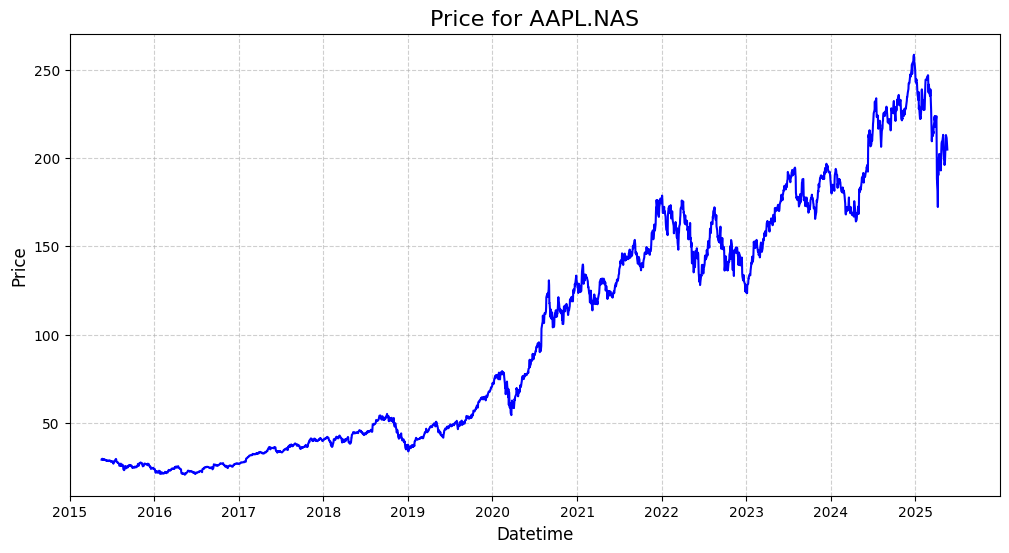

In [5]:
# Filtering data for the current symbol
symbol = "AAPL.NAS"
symbol_df = full_df[full_df["Symbol"] == symbol].copy()

# Price Plot
plt.figure(figsize=(12, 6))
plt.plot(symbol_df["Datetime"], symbol_df["Close"], label="Close Price", color="blue")
plt.title(f"Price for {symbol}", fontsize=16)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Set x-axis to show ticks every year and ensure it only spans the data range
start_year = symbol_df["Datetime"].min().year
end_year = symbol_df["Datetime"].max().year
plt.gca().set_xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))

In [6]:
# Descriptive Statistics
print(f"\nDescriptive Statistics:\n")
desc_stats = symbol_df["Close"].describe().to_frame().transpose()
desc_stats


Descriptive Statistics:



,count,mean,std,min,25%,50%,75%,max
Close,2516.0,101.284755,68.518814,20.647457,37.44103,77.675419,161.180534,258.396667


In [7]:
symbol_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Symbol    2516 non-null   object 
 1   Datetime  2516 non-null   object 
 2   Open      2516 non-null   float64
 3   High      2516 non-null   float64
 4   Low       2516 non-null   float64
 5   Close     2516 non-null   float64
 6   Volume    2516 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 157.2+ KB


# Modelling

## Forecast using Polynomial Regression

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


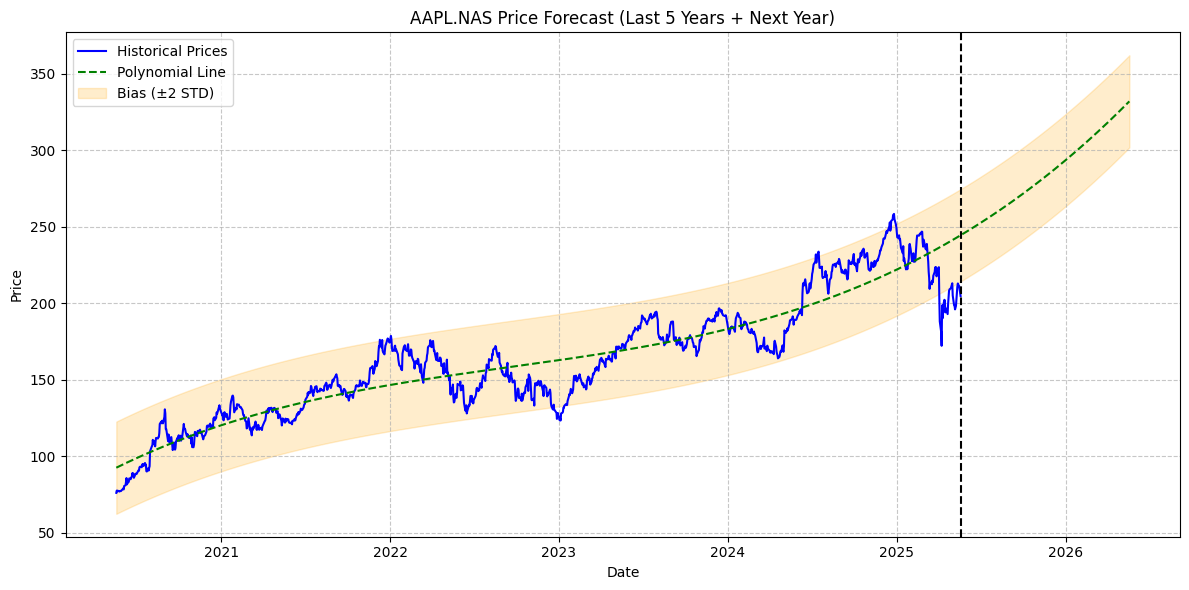

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Selecting the specified symbol
symbol = "AAPL.NAS"
symbol_df = full_df[full_df["Symbol"] == symbol][["Datetime", "Close"]].dropna().copy()

# Converting 'Datetime' column to datetime format
symbol_df['Datetime'] = pd.to_datetime(symbol_df['Datetime'])

# Filtering data for the last 5 years
symbol_df = symbol_df[symbol_df["Datetime"] >= symbol_df["Datetime"].max() - pd.DateOffset(years=5)]

# Creating the feature (day number) and target (Close price)
symbol_df['day_number'] = (symbol_df['Datetime'] - symbol_df['Datetime'].min()).dt.days
X = symbol_df[['day_number']]
y = symbol_df['Close']

# Polynomial Regression (Degree 3)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)

# Bias Calculation (Standard Deviation of Residuals) - ±2 STD
y_pred = model.predict(X_poly)
std_bias = 2 * np.std(y - y_pred)

# Forecasting Next Year (365 Days)
future_days = np.arange(X['day_number'].max() + 1, X['day_number'].max() + 366).reshape(-1, 1)
future_days_poly = poly.transform(future_days)
future_forecast = model.predict(future_days_poly)

# Combined Upper and Lower Bound Calculation (±2 STD)
upper_bound = np.concatenate([y_pred + std_bias, future_forecast + std_bias])
lower_bound = np.concatenate([y_pred - std_bias, future_forecast - std_bias])

# Full Dates for Plotting
full_dates = pd.concat([
    symbol_df['Datetime'],
    pd.Series(pd.date_range(symbol_df['Datetime'].max() + pd.Timedelta(days=1), periods=365))
]).reset_index(drop=True)

# Plotting Historical and Forecasted Data
plt.figure(figsize=(12, 6))
plt.plot(symbol_df['Datetime'], symbol_df['Close'], label="Historical Prices", color='blue')
plt.plot(full_dates, np.concatenate([y_pred, future_forecast]), linestyle='--', color='green', label="Polynomial Line")

# Bias (±2 STD) Plot (Unified for Historical + Forecast)
plt.fill_between(full_dates, upper_bound, lower_bound, color='orange', alpha=0.2, label="Bias (±2 STD)")

# Vertical Line for Forecast Start (No Legend)
plt.axvline(symbol_df['Datetime'].max(), linestyle='--', color='black')

# Title and Labels
plt.title(f"{symbol} Price Forecast (Last 5 Years + Next Year)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Backtest

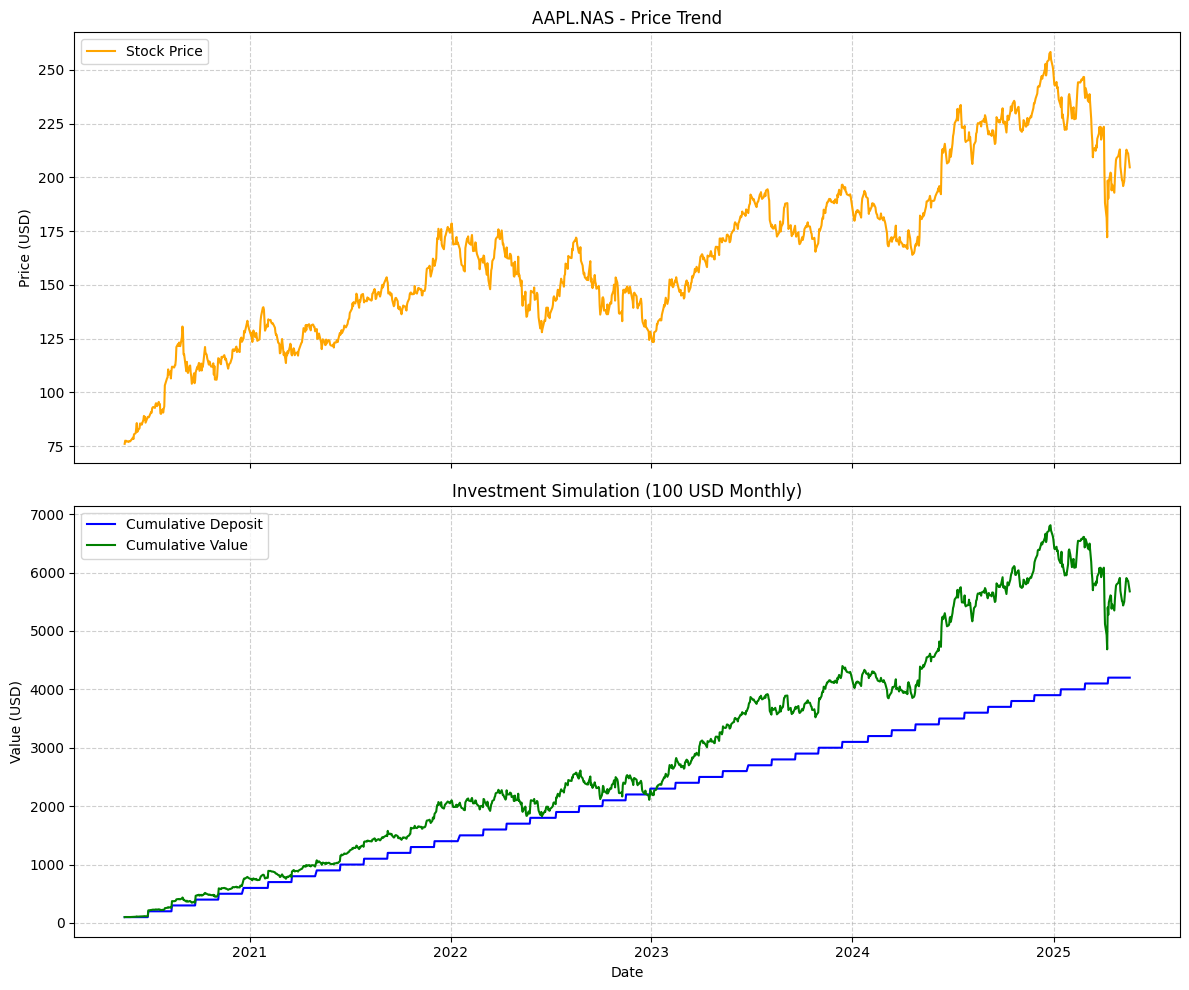

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming full_df is already loaded from the existing code
symbol = "AAPL.NAS"
symbol_df = full_df[full_df["Symbol"] == symbol][["Datetime", "Close"]].dropna().copy()
symbol_df["Datetime"] = pd.to_datetime(symbol_df["Datetime"])

# Filtering data for the last 5 years
symbol_df = symbol_df[symbol_df["Datetime"] >= symbol_df["Datetime"].max() - pd.DateOffset(years=5)]
symbol_df = symbol_df.sort_values("Datetime").reset_index(drop=True)

# Setting the initial investment and monthly deposit
monthly_investment = 100

# Initializing lists to track cumulative values
cumulative_deposit = []
cumulative_value = []

# Simulating monthly investments
total_deposit = 0
current_value = 0

for i, row in symbol_df.iterrows():
    if i % 30 == 0:  # Simulate monthly deposit
        total_deposit += monthly_investment
        current_value += monthly_investment / row['Close']  # Buying at closing price

    # Calculating the current investment value
    current_value_in_usd = current_value * row['Close']
    cumulative_deposit.append(total_deposit)
    cumulative_value.append(current_value_in_usd)

# Calculating the final annual return
final_investment_value = cumulative_value[-1]
annual_return_percentage = ((final_investment_value - total_deposit) / total_deposit) * 100

# Plotting the Results with Subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Price Trend Plot
ax[0].plot(symbol_df["Datetime"], symbol_df["Close"], label="Stock Price", color="orange")
ax[0].set_title(f"{symbol} - Price Trend")
ax[0].set_ylabel("Price (USD)")
ax[0].grid(True, linestyle="--", alpha=0.6)
ax[0].legend()

# Investment Simulation Plot
ax[1].plot(symbol_df["Datetime"], cumulative_deposit, label="Cumulative Deposit", color="blue")
ax[1].plot(symbol_df["Datetime"], cumulative_value, label="Cumulative Value", color="green")
ax[1].set_title(f"Investment Simulation (100 USD Monthly)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Value (USD)")
ax[1].grid(True, linestyle="--", alpha=0.6)
ax[1].legend()

# Adjusting layout
plt.tight_layout()
plt.show()

In [10]:
# Displaying Final Investment Summary
final_deposit = cumulative_deposit[-1]
final_value = cumulative_value[-1]
final_return_percentage = ((final_value - final_deposit) / final_deposit) * 100

print(f"Final Cumulative Deposit: ${final_deposit:,.2f}")
print(f"Final Investment Value: ${final_value:,.2f}")
print(f"Total Return: {final_return_percentage:.2f}%")

Final Cumulative Deposit: $4,200.00
Final Investment Value: $5,676.72
Total Return: 35.16%


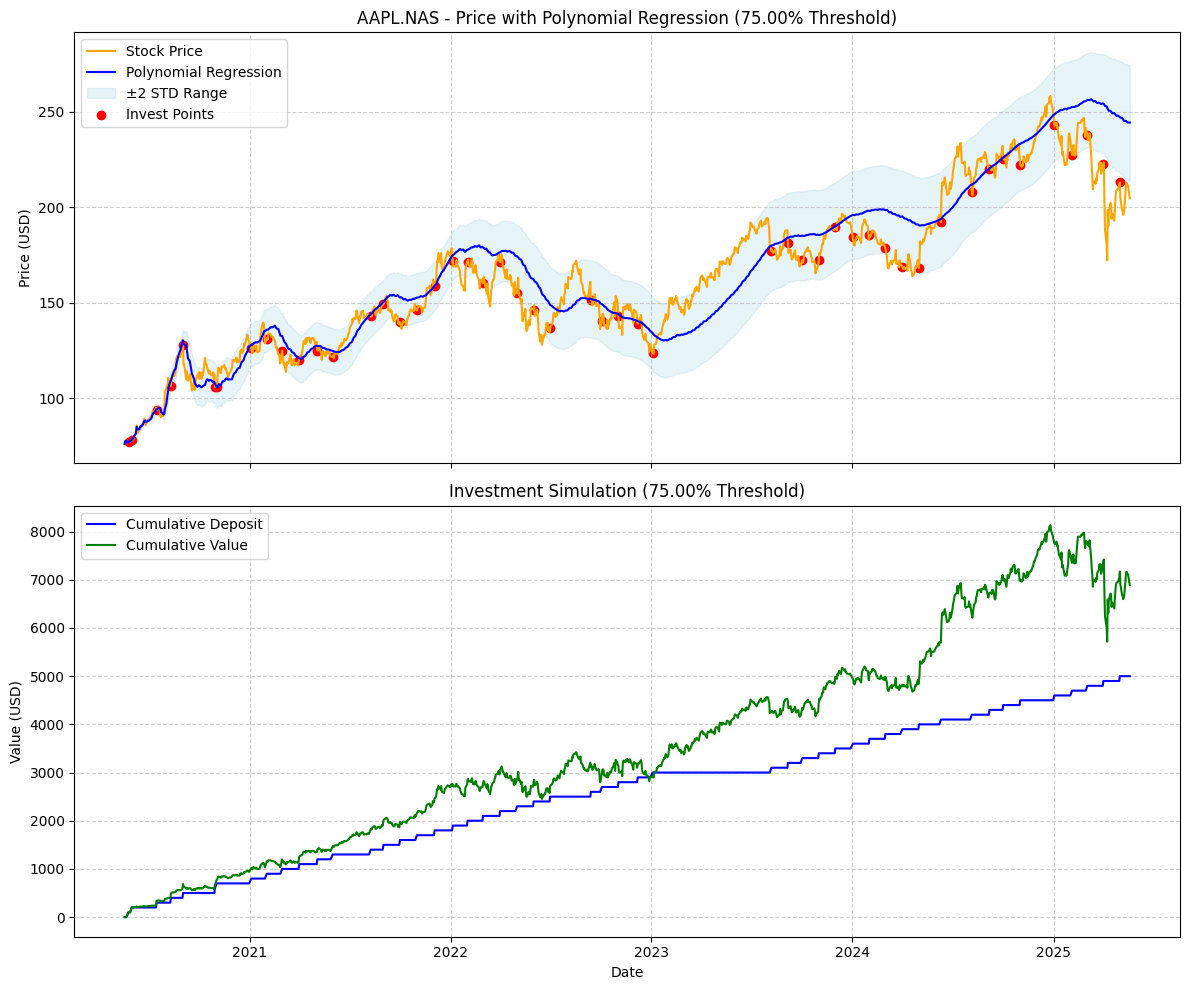

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Assuming full_df is already loaded from the existing code
symbol = "AAPL.NAS"
symbol_df = full_df[full_df["Symbol"] == symbol][["Datetime", "Close"]].dropna().copy()
symbol_df["Datetime"] = pd.to_datetime(symbol_df["Datetime"])

# Filtering data for the last 5 years
symbol_df = symbol_df[symbol_df["Datetime"] >= symbol_df["Datetime"].max() - pd.DateOffset(years=5)]
symbol_df = symbol_df.sort_values("Datetime").reset_index(drop=True)

# Customizable threshold percentage (Default 75%)
threshold_percentage = 0.75

# Initializing variables
total_deposit = 0
current_value = 0
cumulative_deposit = []
cumulative_value = []
invest_dates = []  # Tracking investment dates
invest_prices = []  # Tracking investment prices
poly_predictions = []
std_upper = []
std_lower = []

# Tracking the month for monthly investment limit
last_investment_month = None
monthly_investment = 100

for date in symbol_df["Datetime"]:
    # Subset the data up to the current date
    data_subset = symbol_df[symbol_df["Datetime"] <= date].copy()
    data_subset['day_number'] = (data_subset['Datetime'] - data_subset['Datetime'].min()).dt.days

    # Polynomial Regression Model
    X = data_subset[['day_number']]
    y = data_subset['Close']

    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # Prediction and 2-STD range calculation for each point
    y_pred = model.predict(X_poly)
    std_bias = 2 * np.std(y - y_pred)

    # Calculate the exact lower and upper bound for the current date
    lower_bound_value = y_pred[-1] - std_bias
    upper_bound_value = y_pred[-1] + std_bias

    # Store for plotting
    poly_predictions.append(y_pred[-1])
    std_upper.append(upper_bound_value)
    std_lower.append(lower_bound_value)

    # Correct Threshold Calculation
    threshold = lower_bound_value + (threshold_percentage * (upper_bound_value - lower_bound_value))
    current_price = data_subset.iloc[-1]['Close']

    # Only invest if it's a new month
    if last_investment_month is None or date.month != last_investment_month:
        # Buy condition: price below the calculated threshold
        if current_price < threshold and current_price < y_pred[-1]:
            total_deposit += monthly_investment
            current_value += monthly_investment / current_price  # Buying at current price
            invest_dates.append(date)  # Recording the investment date
            invest_prices.append(current_price)  # Recording the investment price
            last_investment_month = date.month  # Update last investment month

    # Tracking cumulative values
    current_value_in_usd = current_value * current_price
    cumulative_deposit.append(total_deposit)
    cumulative_value.append(current_value_in_usd)

# Calculating the final annual return
final_investment_value = cumulative_value[-1]
investment_duration_years = (symbol_df["Datetime"].max() - symbol_df["Datetime"].min()).days / 365
annual_return_percentage = ((final_investment_value - total_deposit) / total_deposit) / investment_duration_years * 100

# Plotting with Subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Subplot 1: Price with Polynomial Regression, STD, and Invest Points
ax[0].plot(symbol_df["Datetime"], symbol_df["Close"], label="Stock Price", color="orange")
ax[0].plot(symbol_df["Datetime"], poly_predictions, label="Polynomial Regression", color="blue")
ax[0].fill_between(symbol_df["Datetime"], std_upper, std_lower, color="lightblue", alpha=0.3, label="±2 STD Range")

# Plotting the investment points only if they are below the threshold
ax[0].scatter(invest_dates, invest_prices, color="red", marker="o", label="Invest Points")

ax[0].set_title(f"{symbol} - Price with Polynomial Regression ({threshold_percentage * 100:.2f}% Threshold)")
ax[0].set_ylabel("Price (USD)")
ax[0].grid(True, linestyle="--", alpha=0.6)
ax[0].legend()

# Subplot 2: Investment Simulation
ax[1].plot(symbol_df["Datetime"], cumulative_deposit, label="Cumulative Deposit", color="blue")
ax[1].plot(symbol_df["Datetime"], cumulative_value, label="Cumulative Value", color="green")
ax[1].set_title(f"Investment Simulation ({threshold_percentage * 100:.2f}% Threshold)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Value (USD)")
ax[1].grid(True, linestyle="--", alpha=0.6)
ax[1].legend()

plt.tight_layout()
plt.show()


In [12]:
# Displaying Final Investment Summary
final_deposit = cumulative_deposit[-1]
final_value = cumulative_value[-1]
final_return_percentage = ((final_value - final_deposit) / final_deposit) * 100

print(f"Final Cumulative Deposit: ${final_deposit:,.2f}")
print(f"Final Investment Value: ${final_value:,.2f}")
print(f"Total Return: {final_return_percentage:.2f}%")

Final Cumulative Deposit: $5,000.00
Final Investment Value: $6,890.86
Total Return: 37.82%


# Export Data to Google Sheets

To use the Google Sheets API in Python, follow these steps:

Step 1: Set Up Google Cloud Project and Enable API
Go to the Google Cloud Console:

Visit Google Cloud Console.

Create a New Project:

Click on "Select Project" > "New Project".

Give your project a name.

Enable Google Sheets API and Google Drive API:

Go to APIs & Services > Library.

Search for "Google Sheets API" and "Google Drive API".

Click "Enable" for both.

Create Credentials (Service Account Key):

Go to APIs & Services > Credentials.

Click "Create Credentials" > "Service Account".

Fill in the details and create the service account.

Go to the service account you created, and click "Add Key" > "JSON".

Download the JSON file — this will be your credentials file.

Step 2: Share Your Google Sheet with the Service Account
Open your Google Sheet.

Click "Share" in the top right.

Share with the Service Account Email:

Find the email address of your service account in the JSON file.

Share your Google Sheet with this email address (give it "Editor" permission).

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# List of all symbols you want to forecast
symbols = full_df['Symbol'].unique()
forecast_dfs = []

for symbol in symbols:
    # Selecting the specified symbol
    symbol_df = full_df[full_df["Symbol"] == symbol][["Datetime", "Close"]].dropna().copy()

    # Converting 'Datetime' column to datetime format
    symbol_df['Datetime'] = pd.to_datetime(symbol_df['Datetime'])

    # Filtering data for the last 5 years
    symbol_df = symbol_df[symbol_df["Datetime"] >= symbol_df["Datetime"].max() - pd.DateOffset(years=5)]

    # Creating the feature (day number) and target (Close price)
    symbol_df['day_number'] = (symbol_df['Datetime'] - symbol_df['Datetime'].min()).dt.days
    X = symbol_df[['day_number']]
    y = symbol_df['Close']

    # Polynomial Regression (Degree 3)
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)

    # Bias Calculation (Standard Deviation of Residuals) - ±2 STD
    y_pred = model.predict(X_poly)
    std_bias = 2 * np.std(y - y_pred)

    # Forecasting Next Year (365 Days)
    future_days = np.arange(X['day_number'].max() + 1, X['day_number'].max() + 366).reshape(-1, 1)
    future_days_poly = poly.transform(future_days)
    future_forecast = model.predict(future_days_poly)

    # Calculating Upper and Lower Bound (±2 STD)
    upper_bound = future_forecast + std_bias
    lower_bound = future_forecast - std_bias

    # Forecast Dates
    forecast_dates = pd.date_range(symbol_df['Datetime'].max() + pd.Timedelta(days=1), periods=365)

    # Creating the Forecast DataFrame for this symbol
    forecast_df = pd.DataFrame({
        "Symbol": symbol,
        "Date": forecast_dates,
        "Forecast_Price": future_forecast,
        "Upper_Bound": upper_bound,
        "Lower_Bound": lower_bound
    })

    forecast_dfs.append(forecast_df)

# Merging all forecast dataframes for all symbols
all_forecast_df = pd.concat(forecast_dfs, ignore_index=True)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [15]:
from google_sheet_api import GoogleSheetsUploader

CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")

# Upload results to Google Sheets
try:
    print("📤 Uploading to Google Sheets...")
    uploader = GoogleSheetsUploader(CREDENTIAL_PATH, "Stock Analysis")
    uploader.upload_dataframe(full_df, "Price", replace=True)
    print("✅ Upload successful!")
except Exception as e:
    print(f"❌ Upload failed: {e}")

try:
    print("📤 Uploading to Google Sheets...")
    uploader = GoogleSheetsUploader(CREDENTIAL_PATH, "Stock Analysis")
    uploader.upload_dataframe(all_forecast_df, "Forecast", replace=True)
    print("✅ Upload successful!")
except Exception as e:
    print(f"❌ Upload failed: {e}")

📤 Uploading to Google Sheets...
✅ Cleared all data from sheet: Price
✅ DataFrame successfully uploaded to Google Sheets: Price!
✅ Upload successful!
📤 Uploading to Google Sheets...
✅ Cleared all data from sheet: Forecast
✅ DataFrame successfully uploaded to Google Sheets: Forecast!
✅ Upload successful!
